In [1]:
import json
from operator import index
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import time

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
#import tensorflow as tf

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('once', '.*sliced data.*', )
warnings.filterwarnings('once', '.*Maximum iterations*', )

/home/max/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def prepare_dataset(path : str, workload_name : str):
    dataset = {}
    files = os.listdir(path)

    for file in files:
        with open(path+"/"+file, "r") as f:
            raw_str = f.read()
        data = json.loads(raw_str)

        if "layers" in data.keys():
            del data["layers"]

        if "relay" in data.keys():
            del data["relay"]

        if "conv2d" in workload_name:
            data["kernel_0"] = data["kernel"][0]
            data["kernel_1"] = data["kernel"][1]
            del data["kernel"]
            data["dilation_0"] = data["dilation"][0]
            data["dilation_1"] = data["dilation"][1]
            del data["dilation"]

            if not "kernel layout" in data.keys():
                data["kernel layout"] = "OIHW"

        elif workload_name == "dense":
            data["features"] = data["input shape"][1]
            del data["input shape"]
            del data["output shape"]
            #print()

        elif workload_name in ["max_pool2d", "avg_pool2d"]:
            data["pool_0"] = data["pool_size"][0]
            data["pool_1"] = data["pool_size"][1]
            del data["pool_size"]

        if workload_name in ["max_pool2d", "avg_pool2d", "conv2d", "dilated_conv2d", "depthwise_conv2d"]:
            del data["padding"]
            data["C_I"] = data["input shape"][3]
            data["H_I"] = data["input shape"][1]
            data["W_I"] = data["input shape"][2]
            del data["input shape"]

            data["C_O"] = data["output shape"][3]
            data["H_O"] = data["output shape"][1]
            data["W_O"] = data["output shape"][2]
            del data["output shape"]

            key = "strides"
            if "stride" in data.keys():
                key = "stride"
            #print(key)
            data["strides_0"] = data[key][0]
            data["strides_1"] = data[key][1]
            del data["strides"]
            if "stride" in data.keys():
                del data["stride"]

        dataset[file] = data

    return dataset

def create_dataframe(dataset : dict, workload_name : str, labels = ["time", "power", "memory"]):
    df = pd.DataFrame.from_dict(dataset, orient='index')
    categoricals = [
        "output dtype",
        "compute dtype",
        "workload",
        ]
    if workload_name in ["conv2d", "max_pool2d", "avg_pool2d", "depthwise_conv2d", "dilated_conv2d"]:
        if "data_layout" in list(df.columns):
            categoricals += [
                #"padding",
                "data_layout",
            ]
        else:    
            categoricals += [
                #"padding",
                "data layout",
            ]
        

    if "conv2d" in workload_name:
        if "kernel_layout" in list(df.columns):
            categoricals += [
                "kernel_layout",
            ]
        if "kernel layout" in list(df.columns):
            categoricals += [
                "kernel layout",
            ]

    for col in categoricals:
        oh = pd.get_dummies(df[col], prefix=col, drop_first=False)
        df = pd.concat([df, oh], axis=1).drop(col, axis=1)
    
    features = list(df.columns)
    #labels = ["time", "power", "memory"]
    for label in labels:
        idx = features.index(label)
        del features[idx]
    del idx
    df = df.drop_duplicates(subset=features)

    label_data = []
    for label in labels:
        label_data.append(df[label])
        df.pop(label)

    output = pd.concat(label_data, axis=1)

    return df, output

In [4]:
!ls dataset/

 cuda_980ti		      'llvm -mcpu=haswell_E5-2680_faulty'
 cuda_A100		       opencl_Mali-T628_MP6
 cuda_K80		       opencl_Mali-T628_MP6_no_power
'llvm -mcpu=haswell_E5-2680'   rasp4b


In [5]:
dataset_base = "./dataset"
targets = os.listdir(dataset_base)

layer_targets = list()
for target in targets:
    target_path = dataset_base + "/" + target
    layers = os.listdir(target_path)
    
    for layer in layers:
        dataset_path = target_path + "/" + layer + "/"
        print(dataset_path)
        layer_targets.append(dataset_path)

print("found {0} folders with samples, going to train models for each of these targets".format(len(layer_targets)))
print()

./dataset/cuda_980ti/avg_pool2d/
./dataset/cuda_980ti/conv2d/
./dataset/cuda_980ti/dense/
./dataset/cuda_980ti/depthwise_conv2d/
./dataset/cuda_980ti/dilated_conv2d/
./dataset/cuda_980ti/max_pool2d/
./dataset/cuda_A100/avg_pool2d/
./dataset/cuda_A100/conv2d/
./dataset/cuda_A100/dense/
./dataset/cuda_A100/depthwise_conv2d/
./dataset/cuda_A100/dilated_conv2d/
./dataset/cuda_A100/max_pool2d/
./dataset/cuda_K80/avg_pool2d/
./dataset/cuda_K80/conv2d/
./dataset/cuda_K80/dense/
./dataset/cuda_K80/depthwise_conv2d/
./dataset/cuda_K80/dilated_conv2d/
./dataset/cuda_K80/max_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/avg_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dense/
./dataset/llvm -mcpu=haswell_E5-2680/depthwise_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dilated_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/max_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680_faulty/conv2d/
./dataset/llvm -mcpu=haswell_E5-2680_faulty/dense/
./dataset/llvm -mcpu=ha

In [6]:
layer_targets = [
#"./dataset/opencl_Mali-T628_MP6/avg_pool2d/",
#"./dataset/opencl_Mali-T628_MP6/conv2d/",
#"./dataset/opencl_Mali-T628_MP6/dense/",
#"./dataset/opencl_Mali-T628_MP6/depthwise_conv2d/",
#"./dataset/opencl_Mali-T628_MP6/dilated_conv2d/",
#"./dataset/opencl_Mali-T628_MP6/max_pool2d/",
    
#"./dataset/llvm -mcpu=haswell_E5-2680/avg_pool2d/",
#"./dataset/llvm -mcpu=haswell_E5-2680/conv2d/",
#"./dataset/llvm -mcpu=haswell_E5-2680/dense/",
##"./dataset/llvm -mcpu=haswell_E5-2680/depthwise_conv2d/",
#"./dataset/llvm -mcpu=haswell_E5-2680/dilated_conv2d/",
#"./dataset/llvm -mcpu=haswell_E5-2680/max_pool2d/",
    
"./dataset/cuda_980ti/avg_pool2d/",
"./dataset/cuda_980ti/conv2d/",
"./dataset/cuda_980ti/dense/",
"./dataset/cuda_980ti/depthwise_conv2d/",
"./dataset/cuda_980ti/dilated_conv2d/",
"./dataset/cuda_980ti/max_pool2d/",
]

In [13]:
layer_targets = [   
"./dataset/cuda_A100/avg_pool2d/",
"./dataset/cuda_A100/conv2d/",
"./dataset/cuda_A100/dense/",
"./dataset/cuda_A100/depthwise_conv2d/",
"./dataset/cuda_A100/dilated_conv2d/",
"./dataset/cuda_A100/max_pool2d/",
]

In [14]:
models = {
    "xgb": xgb.XGBRegressor,
    "ert": ExtraTreesRegressor,
    "dTr": DecisionTreeRegressor,
    #"liR": LinearRegression,
    #"kNN": KNeighborsRegressor,
    #"SVR": SVR,
    "MLP": MLPRegressor,
}

kwargs_dict = {
    "xgb": None,
    "ert": {"n_estimators":175},
    "dTr": {"criterion":"mae", },
    "liR": {"normalize": True, "n_jobs":-1},
    "kNN": {"n_neighbors":3, "weights":"distance"},
    "SVR": {},
    "MLP": {"hidden_layer_sizes":(100,400,200,100,), "max_iter":500},
}

results = {}

In [16]:
for target in layer_targets:
    print(target)
    tmp = target.split("/")
    workload_name = tmp[-2]
    device_name = tmp[-3]
    files = os.listdir(target)
    dataset = {}
    
    labels = ["time", "power", "memory"]
    if device_name == "rasp4b" or device_name == "opencl_Mali-T628_MP6":
        labels = ["time", "power", "ws_size", "io_size"]
    
    print("{} : {}\t:\t contains {} samples".format(workload_name, device_name, len(files)))
    dataset = prepare_dataset(target, workload_name)
    #print("\tLoading data into memory:\tcompleted")
    df, output = create_dataframe(dataset, workload_name, labels=labels)
    #print("\tCreating dataframe:\t\tcompleted")
    print("\t[INFO] Remaining Samples after duplicate elimination:\t{}".format(len(df)))
    #print("\t[INFO] Features that are used as predictor inputs   :\n\t\t{}".format(list(df.columns)))
    #print("\t[INFO] Metrics that are going to be predicted       :\n\t\t{}".format(list(output.columns)))
    #print()
    X = df.to_numpy()
    Y = output.to_numpy()
    labels = list(output.columns)

    #X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    scoring = ["r2", "neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "max_error", "neg_median_absolute_error"]
    for method, constructor in models.items():
        for idx, name in enumerate(labels):
            print()
            print(device_name)
            print(workload_name)
            print(name)
            print(method)
            
            if kwargs_dict[method] != None:
                model = make_pipeline(RobustScaler(), constructor(**kwargs_dict[method]))
            else:
                model = make_pipeline(RobustScaler(), constructor())
                
            #model.fit(X, Y[:,idx])
            score = cross_validate(model, X, Y[:, idx], cv=ShuffleSplit(n_splits=4, test_size=0.2), scoring=scoring)
            #print(score)

            result = {
                "device" : device_name,
                "workload" : workload_name,
                "metric" : name,
                "predictor" : method,
                "r2" : np.mean(score["test_r2"]),
                "max_error" : np.mean(score["test_max_error"])*(-1),
                "mae" : np.mean(score["test_neg_mean_absolute_error"])*(-1),
                "mape" : np.mean(score["test_neg_mean_absolute_percentage_error"])*(-1),
                "medae" : np.mean(score["test_neg_median_absolute_error"])*(-1),
                "fit_time" : np.mean(score["fit_time"]),
                "score_time" : np.mean(score["score_time"]),
                "dataset_min" : Y[:,idx].min(),
                "dataset_max" : Y[:,idx].max(),
                "dataset_mean" : Y[:,idx].mean(),
                "dataset_median" : np.median(Y[:,idx]),
                "dataset_size": len(X),
            }
            print(result)
            #print("R2: {.3f}\tMAE {.3f}\tMAPE {.3f}\tMEDAE {.3f}\tMaxError {.3f}".format(result["r2"],result["mae"],result["mape"],result["medae"],result["max_error"]))
            results[device_name+"-"+workload_name+"-"+name+"-"+method] = result

./dataset/cuda_A100/avg_pool2d/
avg_pool2d : cuda_A100	:	 contains 4510 samples
	[INFO] Remaining Samples after duplicate elimination:	4510
avg_pool2d
time
xgb
{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'time', 'predictor': 'xgb', 'r2': 0.9406298927879163, 'max_error': 4.076526288661956, 'mae': 0.24435896919772204, 'mape': 0.6616841968009838, 'medae': 0.12387790752407904, 'fit_time': 0.3693012595176697, 'score_time': 0.008715152740478516, 'dataset_min': 0.0132537, 'dataset_max': 17.2748, 'dataset_mean': 1.3460943849667404, 'dataset_median': 0.562268, 'dataset_size': 4510}
avg_pool2d
power
xgb
{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'power', 'predictor': 'xgb', 'r2': 0.7630514179755901, 'max_error': 116.70852777099608, 'mae': 22.188196114229257, 'mape': 0.12397628041762104, 'medae': 17.783879852294923, 'fit_time': 0.36572831869125366, 'score_time': 0.010702192783355713, 'dataset_min': 63.9785, 'dataset_max': 347.873, 'dataset_mean': 209.7158521064301

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'time', 'predictor': 'dTr', 'r2': 0.7224673663341775, 'max_error': 9.9887125, 'mae': 0.46725863536585366, 'mape': 0.39178924978210633, 'medae': 0.13652630000000002, 'fit_time': 1.670215666294098, 'score_time': 0.0015884041786193848, 'dataset_min': 0.0132537, 'dataset_max': 17.2748, 'dataset_mean': 1.3460943849667404, 'dataset_median': 0.562268, 'dataset_size': 4510}
avg_pool2d
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.5230019844733972, 'max_error': 178.07275000000004, 'mae': 26.705192073170732, 'mape': 0.14772638599170917, 'medae': 12.227062500000002, 'fit_time': 1.9129084348678589, 'score_time': 0.0016790032386779785, 'dataset_min': 63.9785, 'dataset_max': 347.873, 'dataset_mean': 209.71585210643016, 'dataset_median': 226.703, 'dataset_size': 4510}
avg_pool2d
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.8735498739517473, 'max_error': 6.1357421875, 'mae': 0.43284184018154104, 'mape': 0.15850158708916992, 'medae': 0.149169921875, 'fit_time': 1.6441901922225952, 'score_time': 0.0015289783477783203, 'dataset_min': 0.40625, 'dataset_max': 12.140625, 'dataset_mean': 2.228403027993348, 'dataset_median': 1.25390625, 'dataset_size': 4510}
avg_pool2d
time
MLP
{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.9591833309873316, 'max_error': 3.552841561213281, 'mae': 0.1805006140703812, 'mape': 0.4439272641800289, 'medae': 0.08209376269756838, 'fit_time': 7.1395187973976135, 'score_time': 0.005378901958465576, 'dataset_min': 0.0132537, 'dataset_max': 17.2748, 'dataset_mean': 1.3460943849667404, 'dataset_median': 0.562268, 'dataset_size': 4510}
avg_pool2d
power
MLP
{'device': 'cuda_A100', 'workload': 'avg_pool2d', 'metric': 'power', 'predictor': 'MLP', 'r2'

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'conv2d', 'metric': 'time', 'predictor': 'dTr', 'r2': 0.4301580149148778, 'max_error': 691.0676500000001, 'mae': 6.6512890999613, 'mape': 1.1288769761785593, 'medae': 0.09996635000000001, 'fit_time': 2.11480313539505, 'score_time': 0.0013982653617858887, 'dataset_min': 0.0131166, 'dataset_max': 1139.3200000000002, 'dataset_mean': 8.964296247412458, 'dataset_median': 0.293837, 'dataset_size': 3227}
conv2d
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'conv2d', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.7767883197075045, 'max_error': 166.1845, 'mae': 23.52228482972136, 'mape': 0.12975223741265224, 'medae': 14.128062500000006, 'fit_time': 0.9649415612220764, 'score_time': 0.0019092559814453125, 'dataset_min': 63.972, 'dataset_max': 401.762, 'dataset_mean': 188.45206616052064, 'dataset_median': 181.72, 'dataset_size': 3227}
conv2d
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'conv2d', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.6693715412795778, 'max_error': 3.56591796875, 'mae': 0.045733661474458204, 'mape': 0.03918317815199383, 'medae': 0.001953125, 'fit_time': 1.3036655187606812, 'score_time': 0.0013998150825500488, 'dataset_min': 0.40625, 'dataset_max': 8.39453125, 'dataset_mean': 0.5267530310660056, 'dataset_median': 0.423828125, 'dataset_size': 3227}
conv2d
time
MLP
{'device': 'cuda_A100', 'workload': 'conv2d', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.6212333419565786, 'max_error': 513.3109711227239, 'mae': 8.11305400475762, 'mape': 17.067917230374658, 'medae': 1.56805122752955, 'fit_time': 7.5497928857803345, 'score_time': 0.004770338535308838, 'dataset_min': 0.0131166, 'dataset_max': 1139.3200000000002, 'dataset_mean': 8.964296247412458, 'dataset_median': 0.293837, 'dataset_size': 3227}
conv2d
power
MLP
{'device': 'cuda_A100', 'workload': 'conv2d', 'metric': 'power', 'predictor': 'MLP', 'r2': 0.795054009

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dense', 'metric': 'time', 'predictor': 'dTr', 'r2': 0.96126839081937, 'max_error': 70.520725, 'mae': 0.6877646922048847, 'mape': 0.1513346862493818, 'medae': 0.09957325000000003, 'fit_time': 8.504498720169067, 'score_time': 0.002393782138824463, 'dataset_min': 0.013759799999999999, 'dataset_max': 227.214, 'dataset_mean': 5.9922054194723415, 'dataset_median': 1.47106, 'dataset_size': 18421}
dense
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dense', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.7583843918844552, 'max_error': 160.934625, 'mae': 18.91076153324288, 'mape': 0.07820792061481564, 'medae': 8.777124999999998, 'fit_time': 10.94057047367096, 'score_time': 0.0025603771209716797, 'dataset_min': 62.906, 'dataset_max': 421.439, 'dataset_mean': 258.661170403344, 'dataset_median': 263.027, 'dataset_size': 18421}
dense
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dense', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.9996627625691603, 'max_error': 0.04345703125, 'mae': 0.0014288023660108547, 'mape': 0.0025147096327471545, 'medae': -0.0, 'fit_time': 8.193096280097961, 'score_time': 0.002217113971710205, 'dataset_min': 0.40625, 'dataset_max': 2.193359375, 'dataset_mean': 0.5339417096995277, 'dataset_median': 0.490234375, 'dataset_size': 18421}
dense
time
MLP
{'device': 'cuda_A100', 'workload': 'dense', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.9860170404583694, 'max_error': 23.517674341192006, 'mae': 0.5628120383107582, 'mape': 0.47935449740740477, 'medae': 0.17305563048834086, 'fit_time': 14.616034865379333, 'score_time': 0.03434014320373535, 'dataset_min': 0.013759799999999999, 'dataset_max': 227.214, 'dataset_mean': 5.9922054194723415, 'dataset_median': 1.47106, 'dataset_size': 18421}
dense
power
MLP
{'device': 'cuda_A100', 'workload': 'dense', 'metric': 'power', 'predictor': 'MLP', 'r2': 0.80394688041

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'depthwise_conv2d', 'metric': 'time', 'predictor': 'dTr', 'r2': -0.9018240514562719, 'max_error': 30.631369499999998, 'mae': 0.4835898848425197, 'mape': 1.2198605897430104, 'medae': 0.008620950000000002, 'fit_time': 0.7505009770393372, 'score_time': 0.001289963722229004, 'dataset_min': 0.0139396, 'dataset_max': 109.751, 'dataset_mean': 0.5499722177374853, 'dataset_median': 0.0335588, 'dataset_size': 2537}
depthwise_conv2d
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'depthwise_conv2d', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.8355340358527682, 'max_error': 208.75712500000003, 'mae': 19.95408710629921, 'mape': 0.13930794416878386, 'medae': 4.848937500000011, 'fit_time': 0.596798837184906, 'score_time': 0.0018603801727294922, 'dataset_min': 64.403, 'dataset_max': 412.919, 'dataset_mean': 149.29335376428853, 'dataset_median': 112.458, 'dataset_size': 2537}
depthwise_conv2d
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'depthwise_conv2d', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.7555088527284068, 'max_error': 2.4833984375, 'mae': 0.044538362758366146, 'mape': 0.040583052139554994, 'medae': 0.0029296875, 'fit_time': 0.6789931058883667, 'score_time': 0.0014115571975708008, 'dataset_min': 0.40625, 'dataset_max': 6.58984375, 'dataset_mean': 0.5321260962751281, 'dataset_median': 0.421875, 'dataset_size': 2537}
depthwise_conv2d
time
MLP
{'device': 'cuda_A100', 'workload': 'depthwise_conv2d', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.03995230444350312, 'max_error': 34.078178318353025, 'mae': 0.6989738831735139, 'mape': 6.470695750492163, 'medae': 0.1674336782546357, 'fit_time': 4.829805016517639, 'score_time': 0.003950595855712891, 'dataset_min': 0.0139396, 'dataset_max': 109.751, 'dataset_mean': 0.5499722177374853, 'dataset_median': 0.0335588, 'dataset_size': 2537}
depthwise_conv2d
power
MLP
{'device': 'cuda_A100', 'workload': 'depthwise_conv2d', 'metric': 'po

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dilated_conv2d', 'metric': 'time', 'predictor': 'dTr', 'r2': 0.9503266456029429, 'max_error': 317.70555, 'mae': 1.2468067390209125, 'mape': 0.3245253711602045, 'medae': 0.0006602875000001106, 'fit_time': 14.163539111614227, 'score_time': 0.0019124746322631836, 'dataset_min': 0.0131901, 'dataset_max': 938.972, 'dataset_mean': 9.038710652415364, 'dataset_median': 0.32864, 'dataset_size': 7887}
dilated_conv2d
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dilated_conv2d', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.9185524540879242, 'max_error': 142.72424999999998, 'mae': 12.580561945500634, 'mape': 0.06734610375721578, 'medae': 5.711562499999994, 'fit_time': 7.0280956625938416, 'score_time': 0.001882016658782959, 'dataset_min': 64.338, 'dataset_max': 419.094, 'dataset_mean': 193.45487771015598, 'dataset_median': 190.435, 'dataset_size': 7887}
dilated_conv2d
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'dilated_conv2d', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.9329582806037006, 'max_error': 2.00732421875, 'mae': 0.007595589254594423, 'mape': 0.005565739942186938, 'medae': -0.0, 'fit_time': 7.323965072631836, 'score_time': 0.001735091209411621, 'dataset_min': 0.40625, 'dataset_max': 10.021484375, 'dataset_mean': 0.5353964593635095, 'dataset_median': 0.427734375, 'dataset_size': 7887}
dilated_conv2d
time
MLP
{'device': 'cuda_A100', 'workload': 'dilated_conv2d', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.747580515278861, 'max_error': 609.9041619829072, 'mae': 5.323901318662662, 'mape': 12.70064679377094, 'medae': 1.2056089291073746, 'fit_time': 29.783534049987793, 'score_time': 0.009886622428894043, 'dataset_min': 0.0131901, 'dataset_max': 938.972, 'dataset_mean': 9.038710652415364, 'dataset_median': 0.32864, 'dataset_size': 7887}
dilated_conv2d
power
MLP
{'device': 'cuda_A100', 'workload': 'dilated_conv2d', 'metric': 'power', 'predictor': '

/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'max_pool2d', 'metric': 'time', 'predictor': 'dTr', 'r2': 0.7700473945588759, 'max_error': 7.41042, 'mae': 0.4402095110674158, 'mape': 0.3909732430208708, 'medae': 0.13377924999999996, 'fit_time': 1.5865902304649353, 'score_time': 0.0015807151794433594, 'dataset_min': 0.0133818, 'dataset_max': 13.2881, 'dataset_mean': 1.3532158359856148, 'dataset_median': 0.570174, 'dataset_size': 4449}
max_pool2d
power
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'max_pool2d', 'metric': 'power', 'predictor': 'dTr', 'r2': 0.504900951892038, 'max_error': 190.98175, 'mae': 26.289306882022476, 'mape': 0.14153355940267598, 'medae': 12.517562499999991, 'fit_time': 1.8309848308563232, 'score_time': 0.001515805721282959, 'dataset_min': 63.942, 'dataset_max': 351.928, 'dataset_mean': 209.53219914587547, 'dataset_median': 225.851, 'dataset_size': 4449}
max_pool2d
memory
dTr


/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
/home/max/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


{'device': 'cuda_A100', 'workload': 'max_pool2d', 'metric': 'memory', 'predictor': 'dTr', 'r2': 0.8681781257461935, 'max_error': 5.24560546875, 'mae': 0.4424892468398876, 'mape': 0.16333645609258707, 'medae': 0.157470703125, 'fit_time': 1.5636823773384094, 'score_time': 0.0017186403274536133, 'dataset_min': 0.40625, 'dataset_max': 11.765625, 'dataset_mean': 2.2463514448471567, 'dataset_median': 1.267578125, 'dataset_size': 4449}
max_pool2d
time
MLP
{'device': 'cuda_A100', 'workload': 'max_pool2d', 'metric': 'time', 'predictor': 'MLP', 'r2': 0.980099032159704, 'max_error': 2.726008223670837, 'mae': 0.11439840019312532, 'mape': 0.26872776697406564, 'medae': 0.0460365136500106, 'fit_time': 6.357562303543091, 'score_time': 0.00531923770904541, 'dataset_min': 0.0133818, 'dataset_max': 13.2881, 'dataset_mean': 1.3532158359856148, 'dataset_median': 0.570174, 'dataset_size': 4449}
max_pool2d
power
MLP
{'device': 'cuda_A100', 'workload': 'max_pool2d', 'metric': 'power', 'predictor': 'MLP', 'r2'

In [17]:
date_time = "short_results/results_rbst_scaler_A100_KFold_"+str(int(time.time()))
results = pd.DataFrame.from_dict(results, "index")

In [18]:
results.to_csv(date_time+"-predictor_results.csv")
results.to_excel(date_time+"-predictor_results.xlsx")
results.to_html(date_time+"-predictor_results.html")
results.to_markdown(date_time+"-predictor_results.md")
print("done")

done


In [19]:
results

,device,workload,metric,predictor,r2,max_error,mae,mape,medae,fit_time,score_time,dataset_min,dataset_max,dataset_mean,dataset_median,dataset_size
cuda_A100-avg_pool2d-time-xgb,cuda_A100,avg_pool2d,time,xgb,0.940630,4.076526,0.244359,0.661684,0.123878,0.369301,0.008715,0.013254,17.274800,1.346094,0.562268,4510
cuda_A100-avg_pool2d-power-xgb,cuda_A100,avg_pool2d,power,xgb,0.763051,116.708528,22.188196,0.123976,17.783880,0.365728,0.010702,63.978500,347.873000,209.715852,226.703000,4510
cuda_A100-avg_pool2d-memory-xgb,cuda_A100,avg_pool2d,memory,xgb,0.964444,2.974870,0.242980,0.127675,0.120853,0.404485,0.006448,0.406250,12.140625,2.228403,1.253906,4510
cuda_A100-avg_pool2d-time-ert,cuda_A100,avg_pool2d,time,ert,0.929542,5.267846,0.219089,0.259544,0.080751,1.461426,0.045013,0.013254,17.274800,1.346094,0.562268,4510
cuda_A100-avg_pool2d-power-ert,cuda_A100,avg_pool2d,power,ert,0.744520,109.339654,23.786181,0.129947,20.716557,1.357800,0.045515,63.978500,347.873000,209.715852,226.703000,4510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cuda_A100-max_pool2d-power-dTr,cuda_A100,max_pool2d,power,dTr,0.504901,190.981750,26.289307,0.141534,12.517562,1.830985,0.001516,63.942000,351.928000,209.532199,225.851000,4449
cuda_A100-max_pool2d-memory-dTr,cuda_A100,max_pool2d,memory,dTr,0.868178,5.245605,0.442489,0.163336,0.157471,1.563682,0.001719,0.406250,11.765625,2.246351,1.267578,4449
cuda_A100-max_pool2d-time-MLP,cuda_A100,max_pool2d,time,MLP,0.980099,2.726008,0.114398,0.268728,0.046037,6.357562,0.005319,0.013382,13.288100,1.353216,0.570174,4449
cuda_A100-max_pool2d-power-MLP,cuda_A100,max_pool2d,power,MLP,0.634308,118.682848,28.194079,0.142486,25.444991,29.916270,0.006290,63.942000,351.928000,209.532199,225.851000,4449


In [20]:
results[(results.metric =="power")]

,device,workload,metric,predictor,r2,max_error,mae,mape,medae,fit_time,score_time,dataset_min,dataset_max,dataset_mean,dataset_median,dataset_size
cuda_A100-avg_pool2d-power-xgb,cuda_A100,avg_pool2d,power,xgb,0.763051,116.708528,22.188196,0.123976,17.783880,0.365728,0.010702,63.9785,347.873,209.715852,226.703,4510
cuda_A100-avg_pool2d-power-ert,cuda_A100,avg_pool2d,power,ert,0.744520,109.339654,23.786181,0.129947,20.716557,1.357800,0.045515,63.9785,347.873,209.715852,226.703,4510
cuda_A100-avg_pool2d-power-dTr,cuda_A100,avg_pool2d,power,dTr,0.523002,178.072750,26.705192,0.147726,12.227063,1.912908,0.001679,63.9785,347.873,209.715852,226.703,4510
cuda_A100-avg_pool2d-power-MLP,cuda_A100,avg_pool2d,power,MLP,0.625713,127.539536,29.241694,0.154264,25.904458,18.058517,0.005951,63.9785,347.873,209.715852,226.703,4510
cuda_A100-conv2d-power-xgb,cuda_A100,conv2d,power,xgb,0.922744,130.791108,14.662894,0.085064,10.194439,0.332640,0.005180,63.9720,401.762,188.452066,181.720,3227
cuda_A100-conv2d-power-ert,cuda_A100,conv2d,power,ert,0.865531,125.562605,19.730722,0.109029,14.013592,0.831636,0.034422,63.9720,401.762,188.452066,181.720,3227
cuda_A100-conv2d-power-dTr,cuda_A100,conv2d,power,dTr,0.776788,166.184500,23.522285,0.129752,14.128063,0.964942,0.001909,63.9720,401.762,188.452066,181.720,3227
cuda_A100-conv2d-power-MLP,cuda_A100,conv2d,power,MLP,0.795054,151.191395,25.116900,0.134450,17.568895,18.074751,0.005373,63.9720,401.762,188.452066,181.720,3227
cuda_A100-dense-power-xgb,cuda_A100,dense,power,xgb,0.905950,145.983953,12.492314,0.053926,7.546486,0.608683,0.005551,62.9060,421.439,258.661170,263.027,18421
cuda_A100-dense-power-ert,cuda_A100,dense,power,ert,0.842126,193.004425,16.830217,0.069413,10.705454,2.519251,0.186431,62.9060,421.439,258.661170,263.027,18421


In [11]:
workload = "conv2d"
metric = "time"
df = results[(results.workload == workload) & (results.metric == metric)]
df_r2 = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["r2_train"], df["r2_test"]], axis=1)
df_mae = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["mae_train"], df["mae_test"]], axis=1)
df_mape = pd.concat([df["device"], df["workload"], df["metric"], df["predictor"], df["mape_train"], df["mape_test"]], axis=1)
df_sets = pd.concat([df["device"], df["workload"], df["metric"], df["training set size"], df["validation set size"]], axis=1)
df_sets = df_sets.drop_duplicates()
df_stats = pd.concat([df["device"], df["workload"], df["metric"], df["minimum"], df["maximum"], df["mean"], df["median"]], axis=1)
df_stats = df_stats.drop_duplicates()

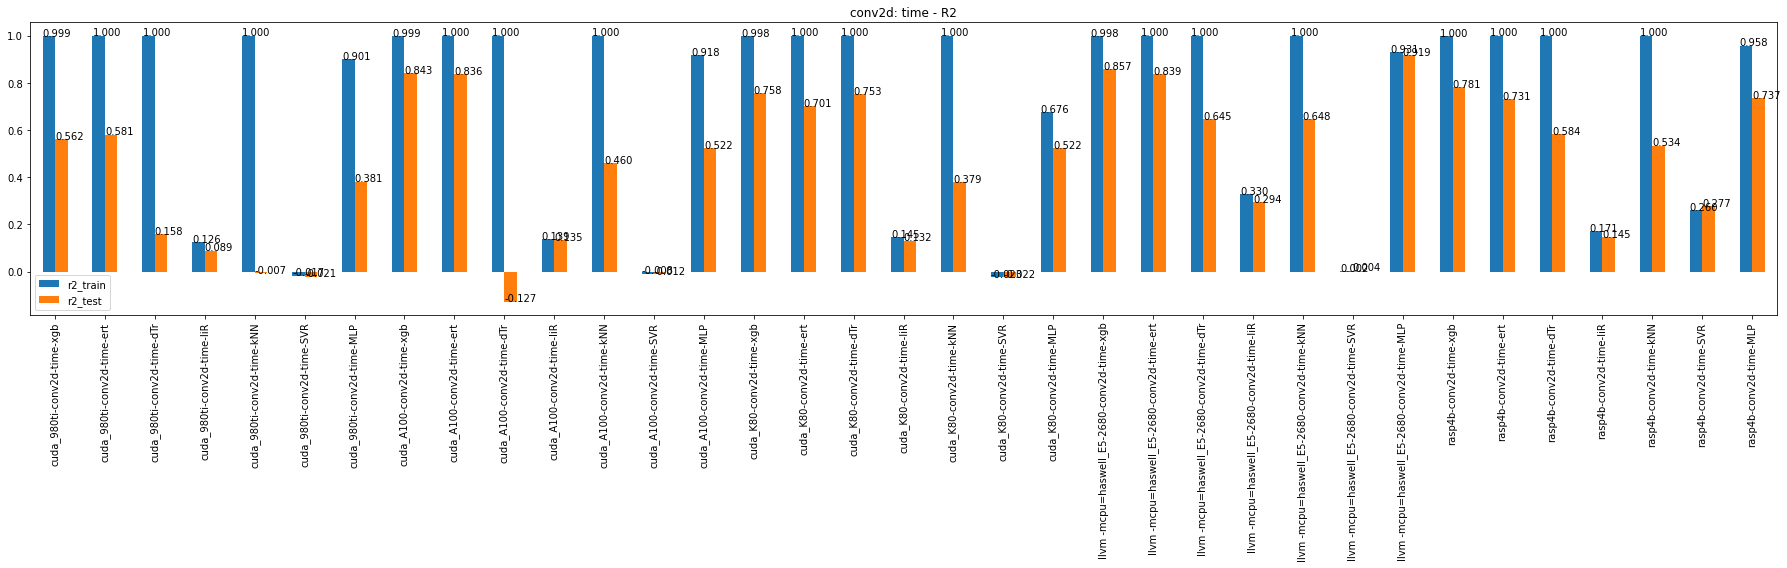

In [12]:
import matplotlib.pyplot as plt
from decimal import Decimal
plt.rcParams["figure.figsize"] = (25,8)
axes = df_r2.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - R2")
plt.tight_layout()
plt.show()

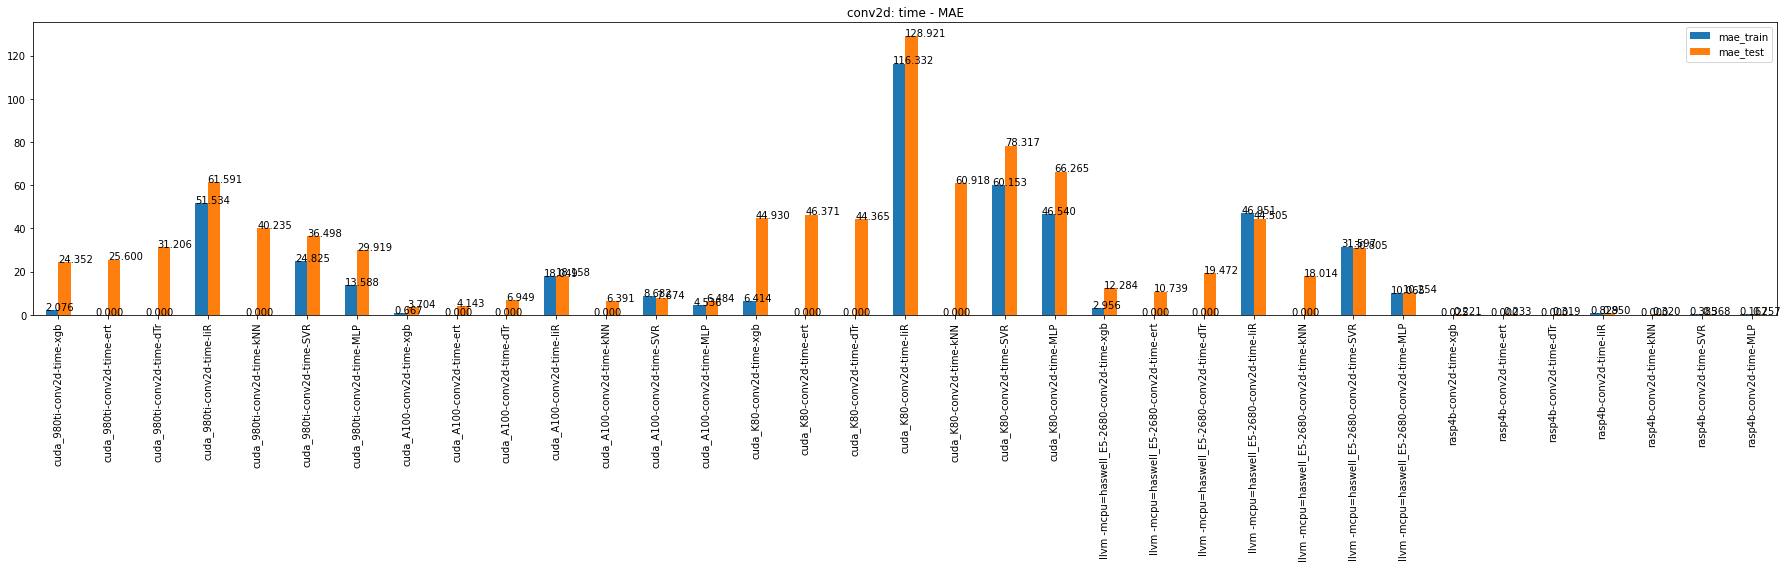

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_mae.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - MAE")
plt.tight_layout()
plt.show()

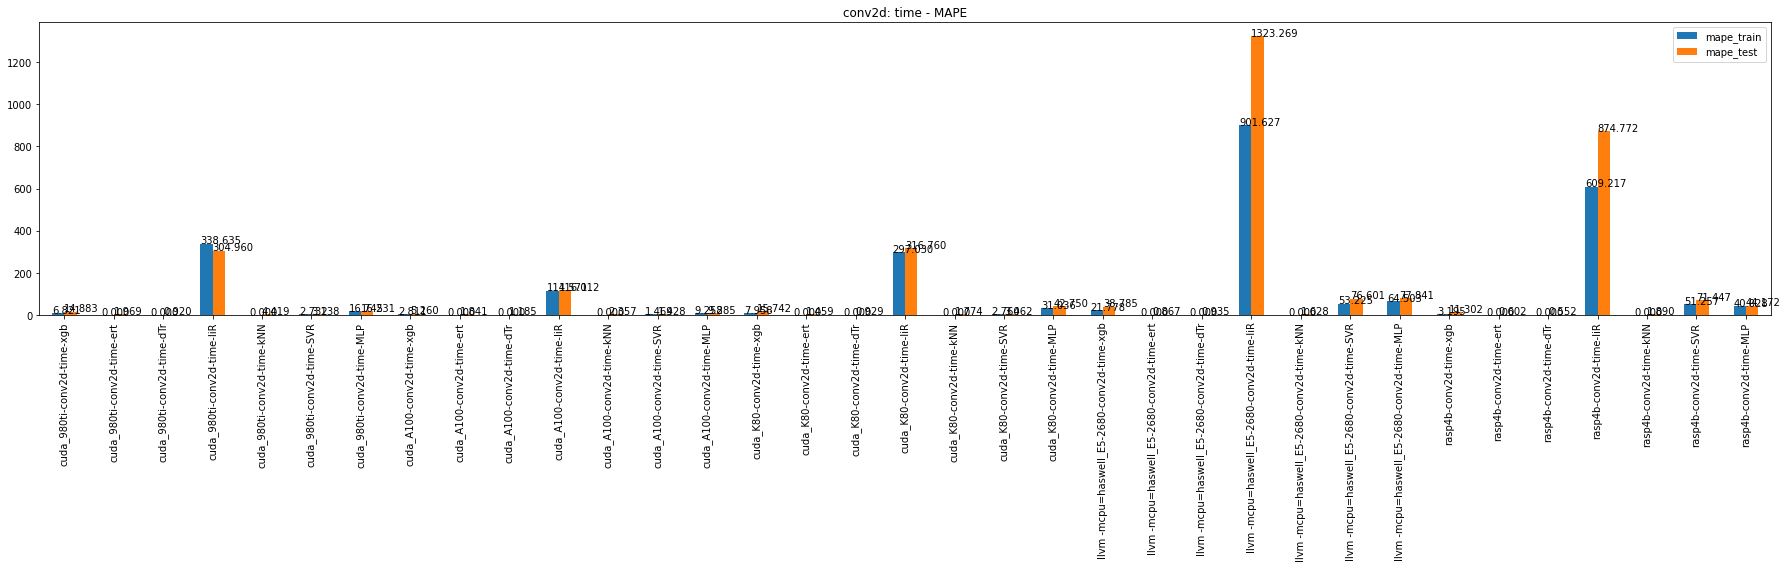

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_mape.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate('{:.3f}'.format(Decimal(str(p.get_height()))), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - MAPE")
plt.tight_layout()
plt.show()

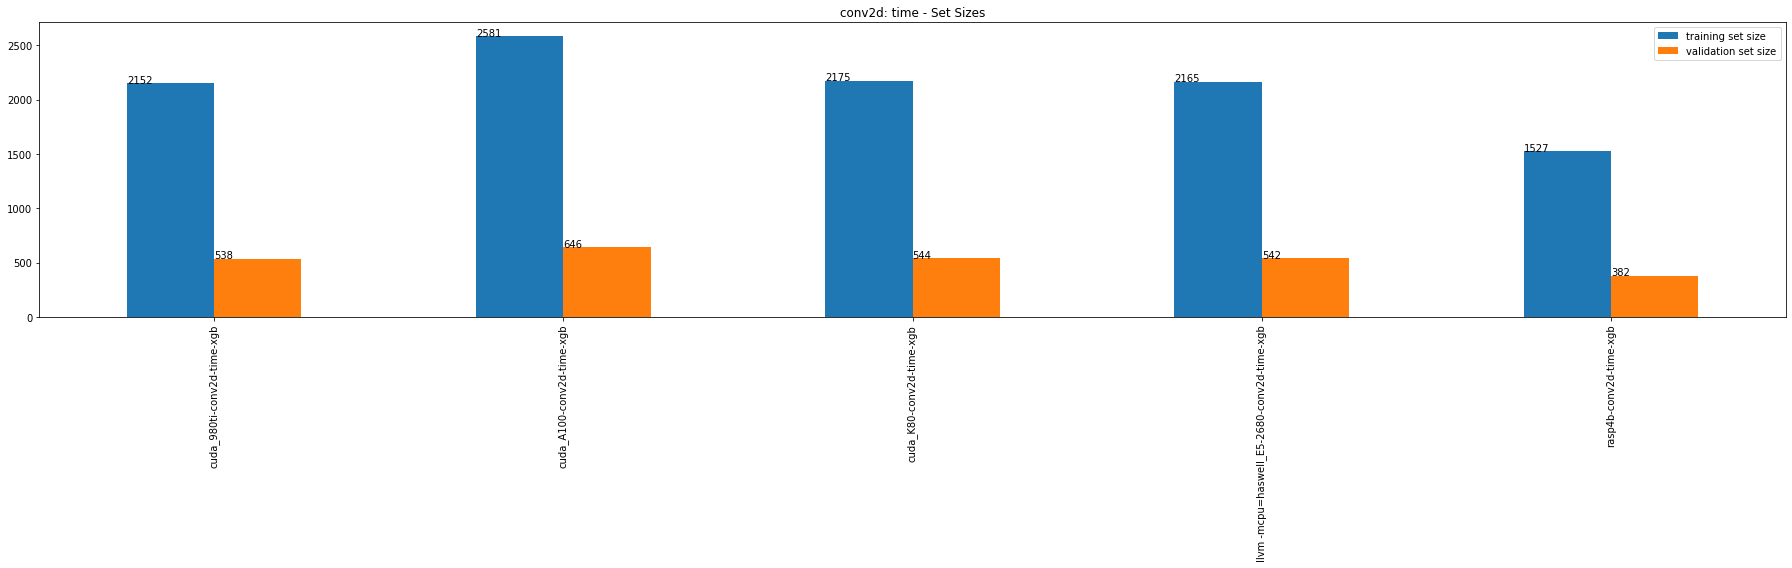

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_sets.plot.bar(subplots=False)
for p in axes.patches:
    axes.annotate(p.get_height(), (p.get_x(), p.get_height()))
plt.title(workload + ": "+metric+" - Set Sizes")
plt.tight_layout()
plt.show()

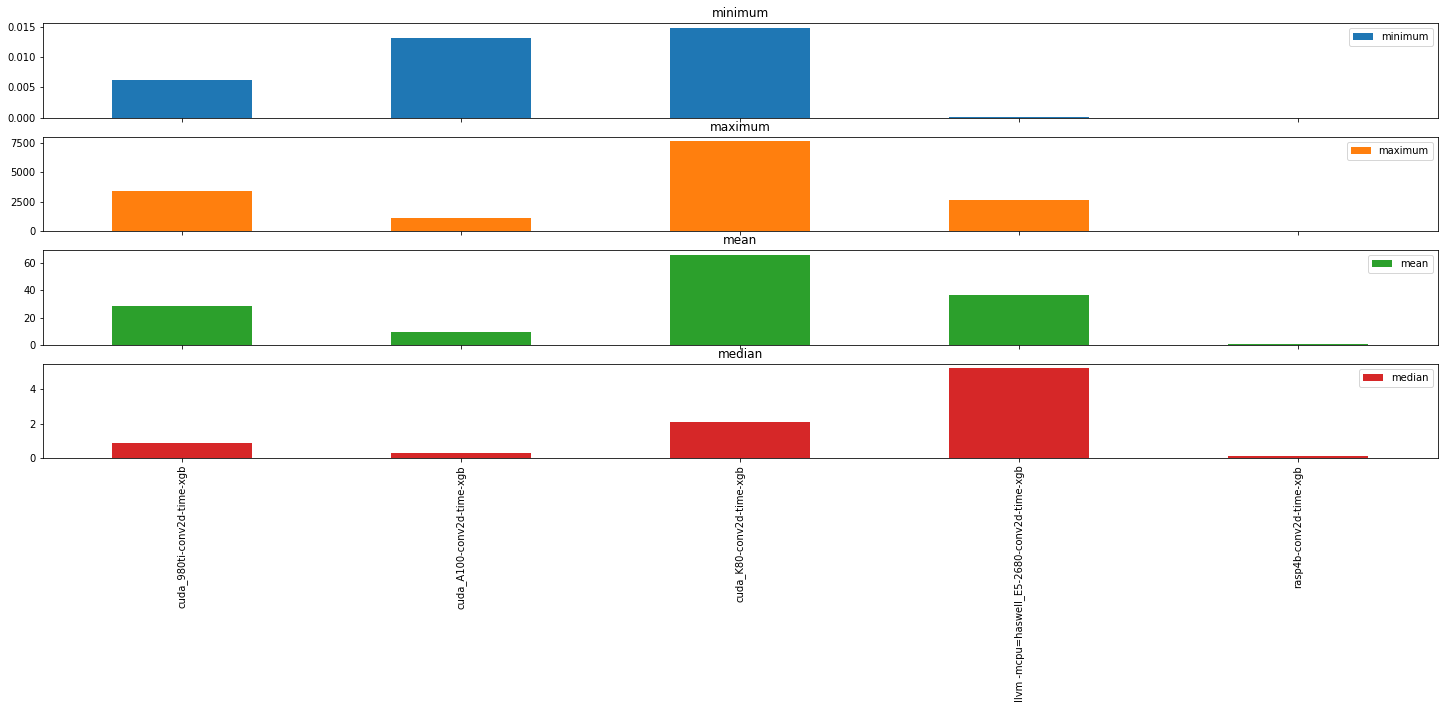

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
axes = df_stats.plot.bar(subplots=True)
#plt.tight_layout()
plt.show()

In [ ]:
df_stats